In [1]:
# !pip install lightgbm

In [2]:
import warnings
warnings.filterwarnings("ignore")

from sklearn._config import set_config
set_config(print_changed_only=False)

In [3]:
import pandas as pd
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
df['target']= y_label
df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [4]:
from sklearn.model_selection import train_test_split

X_features = df.iloc[:, :-1]
y_label = df.iloc[:, -1]

train_X, test_X, train_y, test_y = train_test_split(X_features, y_label, test_size=0.2, random_state=42)
tr_X, eval_X, tr_y, eval_y = train_test_split(train_X, train_y, test_size=0.1, random_state=42)

train_X.shape, test_X.shape, tr_X.shape, eval_X.shape

((455, 30), (114, 30), (409, 30), (46, 30))

In [5]:
from lightgbm import LGBMClassifier

In [6]:
LGBMClassifier?

Init signature:
LGBMClassifier(
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, ForwardRef('np.random.Generator')

In [7]:
model = LGBMClassifier(n_estimators=400, learning_rate=0.05)

evals = [(tr_X, tr_y), (eval_X, eval_y)]
# model.fit(tr_X, tr_y, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
model.fit(tr_X, tr_y, eval_metric="logloss", eval_set=evals)

predict = model.predict(test_X)
predict_proba = model.predict_proba(test_X)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 256, number of negative: 153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4098
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625917 -> initscore=0.514740
[LightGBM] [Info] Start training from score 0.514740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [9]:
get_clf_eval(test_y, predict, predict_proba)

오차 행렬
[[40  3]
 [ 1 70]]
정확도: 0.9649, 정밀도: 0.9589, 재현율: 0.9859,    F1: 0.9722, AUC:0.9898


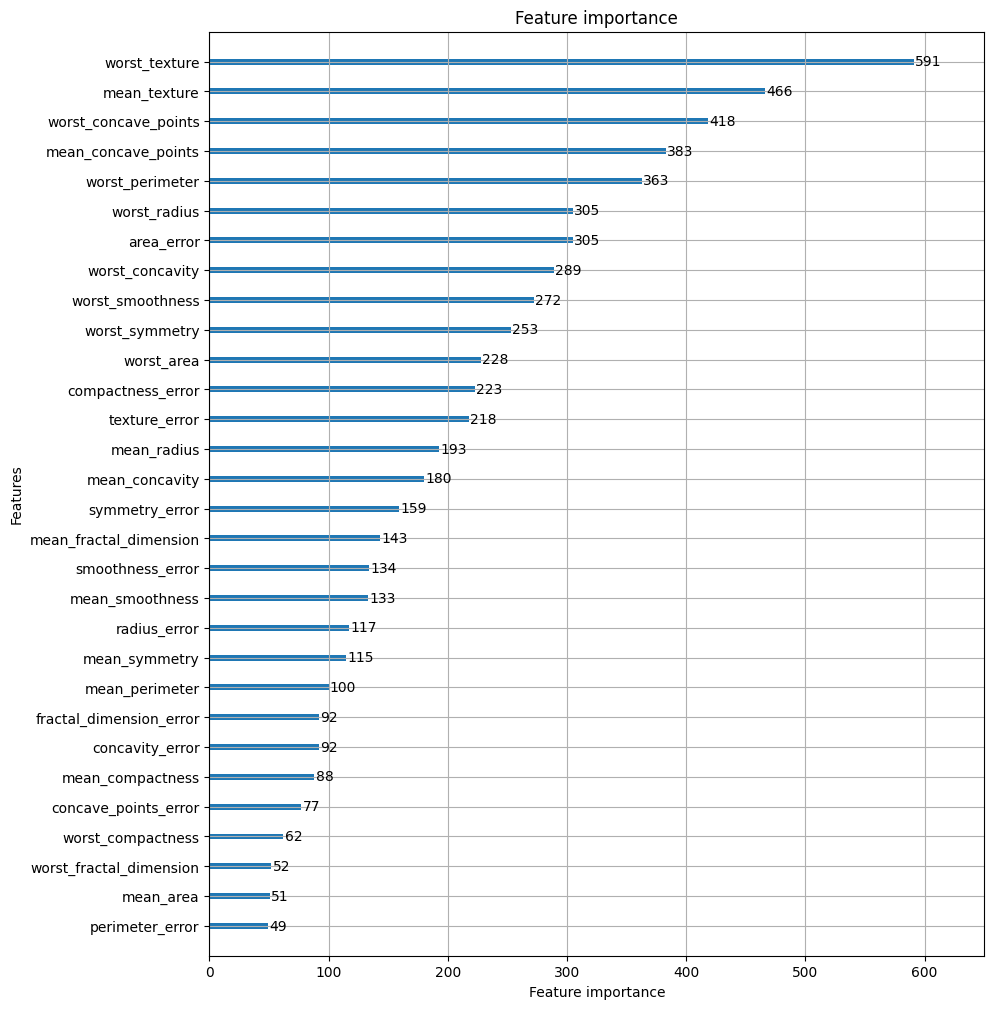

In [10]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(model, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')